In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

Datasets used:
- Exterior temperature of the past 5 months (december to may) at the coordinates 41.50N 2.11E (faculty of enginyeri) which is 133m over the sea so the temperature is from the 120m in that coordinates.
- Sensors placed on the classes, we will focus on the temperature inside the class, using it as the y value.

## Preparing the data

### Limpieza de los datasets

In [ ]:
# Load data from CSV and cleaning it
sensors_data = pd.read_csv('hourly_sensor_data.csv')
sensors_data[['Date', 'Hour']] = sensors_data['Hour'].str.split(' ', expand=True)
sensors_data['Date'] = pd.to_datetime(sensors_data['Date'])
sensors_data['Hour'] = pd.to_datetime(sensors_data['Hour'])
sensors_data['Hour'] = sensors_data['Hour'].dt.time
outside_data = pd.read_csv('open-meteo-41.50N2.11E133m.csv')
outside_data = outside_data.iloc[2:] #deleting first two rows
outside_data = outside_data.iloc[:, :2] #keeping the first two columns
outside_data.columns = ['dia', 'hora']
outside_data['dia'] = pd.to_datetime(outside_data['dia'])
outside_data['fecha'] = outside_data['dia'].dt.date
outside_data['temperatura'] = outside_data['hora']
outside_data['hora'] = outside_data['dia'].dt.time
del outside_data['dia']
outside_data = outside_data[['fecha', 'hora', 'temperatura']]

sensors_data = sensors_data.rename(columns={'Hour': 'hour', 'Date': 'date', 'location': 'location', 'Sensor': 'sensor', 'Average Hourly Value': 'average value'})
outside_data = outside_data.rename(columns={'hora': 'hour', 'fecha': 'date', 'temperatura': 'temperature'})

print(sensors_data)
print(outside_data)


# inside_unique_days = sensors_data['day'].nunique()
# outside_unique_days = outside_data['fecha'].nunique()
# print("Número de días únicos:", inside_unique_days, outside_unique_days)

                 location      hour       sensor  average value       date
0       am3019-testqc2090  14:00:00          co2     464.750000 2023-07-25
1       am3019-testqc2090  14:00:00     humidity      36.000000 2023-07-25
2       am3019-testqc2090  14:00:00  temperature      27.875000 2023-07-25
3       am3019-testqc2090  15:00:00          co2     458.833333 2023-07-25
4       am3019-testqc2090  15:00:00     humidity      35.333333 2023-07-25
...                   ...       ...          ...            ...        ...
114699       q4-1003-7456  11:00:00     humidity      39.833333 2024-03-30
114700       q4-1003-7456  11:00:00  temperature      21.616667 2024-03-30
114701       q4-1003-7456  12:00:00          co2     430.666667 2024-03-30
114702       q4-1003-7456  12:00:00     humidity      38.333333 2024-03-30
114703       q4-1003-7456  12:00:00  temperature      22.350000 2024-03-30

[114704 rows x 5 columns]
            date      hour  temperature
2     2023-12-10  02:00:00       

<ipython-input-2-64b7cd7de011>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sensors_data['Hour'] = pd.to_datetime(sensors_data['Hour'])


### Creación columnas CO2, temperature, humidity

In [ ]:
# Pivotar el DataFrame sensors_data para tener cada sensor como una columna
sensors_pivot = sensors_data.pivot_table(index=['date', 'location', 'hour'], columns='sensor', values='average value')

# Resetear el índice para que 'day' y 'location' se conviertan en columnas
sensors_pivot.reset_index(inplace=True)

# Renombrar las columnas para que coincidan con lo que quieres
sensors_pivot.rename(columns={'co2': 'co2', 'humidity': 'humidity', 'temperature': 'temperature'}, inplace=True)

# Mostrar el DataFrame pivotado
print(sensors_pivot)

# Filtrar filas con valores NaN en las columnas 'co2', 'humidity' y 'temperature'
nan_rows = sensors_pivot[sensors_pivot[['co2', 'humidity', 'temperature']].isna().any(axis=1)]

# Mostrar las filas con valores NaN
print(nan_rows)


sensor       date           location      hour         co2   humidity  \
0      2023-07-25  am3019-testqc2090  14:00:00  464.750000  36.000000   
1      2023-07-25  am3019-testqc2090  15:00:00  458.833333  35.333333   
2      2023-07-25  am3019-testqc2090  16:00:00  481.400000  34.900000   
3      2023-07-25  am3019-testqc2090  17:00:00  486.166667  35.916667   
4      2023-07-25  am3019-testqc2090  18:00:00  461.666667  34.416667   
...           ...                ...       ...         ...        ...   
38247  2024-03-30       q4-1003-7456  08:00:00  408.666667  40.750000   
38248  2024-03-30       q4-1003-7456  09:00:00  404.666667  40.500000   
38249  2024-03-30       q4-1003-7456  10:00:00  407.666667  40.083333   
38250  2024-03-30       q4-1003-7456  11:00:00  438.500000  39.833333   
38251  2024-03-30       q4-1003-7456  12:00:00  430.666667  38.333333   

sensor  temperature  
0         27.875000  
1         27.933333  
2         26.520000  
3         25.866667  
4         25.

### Separación de datasets en función de la ubicación

In [ ]:
# Filtrar y crear dataset para 'am3019-testqc2090'
openLab_Laser_Room_data = sensors_pivot[sensors_pivot['location'] == 'am3019-testqc2090'].copy()
del openLab_Laser_Room_data['location']

# Filtrar y crear dataset para 'am307-9074'
computer_room_data = sensors_pivot[sensors_pivot['location'] == 'am307-9074'].copy()
del computer_room_data['location']

# Filtrar y crear dataset para 'eui-24e124128c147204'
digitalLab_data = sensors_pivot[sensors_pivot['location'] == 'eui-24e124128c147204'].copy()
del digitalLab_data['location']

# Filtrar y crear dataset para 'eui-24e124128c147444'
biblio_de_filosofia_y_lletres_data = sensors_pivot[sensors_pivot['location'] == 'eui-24e124128c147444'].copy()
del biblio_de_filosofia_y_lletres_data['location']

# Filtrar y crear dataset para 'eui-24e124128c147446'
# Agrega el nombre correspondiente a la ubicación
nombre_eui_24e124128c147446_data = sensors_pivot[sensors_pivot['location'] == 'eui-24e124128c147446'].copy()
del nombre_eui_24e124128c147446_data['location']

# Filtrar y crear dataset para 'eui-24e124128c147470'
# Agrega el nombre correspondiente a la ubicación
nombre_eui_24e124128c147470_data = sensors_pivot[sensors_pivot['location'] == 'eui-24e124128c147470'].copy()
del nombre_eui_24e124128c147470_data['location']

# Filtrar y crear dataset para 'eui-24e124128c147499'
audioLab_data = sensors_pivot[sensors_pivot['location'] == 'eui-24e124128c147499'].copy()
del audioLab_data['location']

print("openLab_Laser_Room_data:")
print(openLab_Laser_Room_data)

print("\ncomputer_room_data:")
print(computer_room_data)

print("\ndigitalLab_data:")
print(digitalLab_data)

print("\nbiblio_de_filosofia_y_lletres_data:")
print(biblio_de_filosofia_y_lletres_data)

print("\nnombre_eui_24e124128c147446_data:")
print(nombre_eui_24e124128c147446_data)

print("\nnombre_eui_24e124128c147470_data:")
print(nombre_eui_24e124128c147470_data)

print("\naudioLab_data:")
print(audioLab_data)


openLab_Laser_Room_data:
sensor       date      hour         co2   humidity  temperature
0      2023-07-25  14:00:00  464.750000  36.000000    27.875000
1      2023-07-25  15:00:00  458.833333  35.333333    27.933333
2      2023-07-25  16:00:00  481.400000  34.900000    26.520000
3      2023-07-25  17:00:00  486.166667  35.916667    25.866667
4      2023-07-25  18:00:00  461.666667  34.416667    25.233333
...           ...       ...         ...        ...          ...
38143  2024-03-30  08:00:00  432.600000  39.000000    21.860000
38144  2024-03-30  09:00:00  434.833333  38.916667    21.900000
38145  2024-03-30  10:00:00  435.666667  38.500000    21.916667
38146  2024-03-30  11:00:00  473.000000  38.166667    21.966667
38147  2024-03-30  12:00:00  463.200000  36.500000    22.740000

[5442 rows x 5 columns]

computer_room_data:
sensor       date      hour         co2   humidity  temperature
10     2023-07-25  14:00:00  430.000000  37.000000    27.475000
11     2023-07-25  15:00:00  421.

### Datasets organized by ubication and a counter of the NaN values

In [ ]:
inside_data = [
    openLab_Laser_Room_data,
    computer_room_data,
    digitalLab_data,
    biblio_de_filosofia_y_lletres_data,
    nombre_eui_24e124128c147446_data,
    nombre_eui_24e124128c147470_data,
    audioLab_data
]

# Para imprimir todos los DataFrames dentro de inside_data
for data in inside_data:
    print(data)
    print()
    nan_count = data.isna().sum()
    print("NaN count for", data.index.name, ":", nan_count)
    print()

print(outside_data)
# Contar los valores NaN en outside_data
nan_count_outside = outside_data.isna().sum()

# Mostrar el número de valores NaN en outside_data
print("NaN count in outside_data:")
print(nan_count_outside)


sensor       date      hour         co2   humidity  temperature
0      2023-07-25  14:00:00  464.750000  36.000000    27.875000
1      2023-07-25  15:00:00  458.833333  35.333333    27.933333
2      2023-07-25  16:00:00  481.400000  34.900000    26.520000
3      2023-07-25  17:00:00  486.166667  35.916667    25.866667
4      2023-07-25  18:00:00  461.666667  34.416667    25.233333
...           ...       ...         ...        ...          ...
38143  2024-03-30  08:00:00  432.600000  39.000000    21.860000
38144  2024-03-30  09:00:00  434.833333  38.916667    21.900000
38145  2024-03-30  10:00:00  435.666667  38.500000    21.916667
38146  2024-03-30  11:00:00  473.000000  38.166667    21.966667
38147  2024-03-30  12:00:00  463.200000  36.500000    22.740000

[5442 rows x 5 columns]

NaN count for None : sensor
date           0
hour           0
co2            0
humidity       0
temperature    0
dtype: int64

sensor       date      hour         co2   humidity  temperature
10     2023-07-

### Fusión de los dos datasets en uno solo

In [ ]:
# We are working with inside_data and outside_data
# Lista de nombres originales de los datasets
inside_data_names = [
    'Laser_Room',
    'Computer_Room',
    'DigitalLab',
    'Biblio_de_filosofia_y_lletres',
    'Nombre_eui_24e124128c147446',
    'Nombre_eui_24e124128c147470',
    'AudioLab'
]

merged_datasets = {}  # Diccionario para almacenar los datasets fusionados

# Convertir la columna 'date' a tipo datetime y 'hour' a string en outside_data
outside_data['date'] = pd.to_datetime(outside_data['date'])
outside_data['hour'] = outside_data['hour'].astype(str)


# for data_name, data in zip(inside_data_names, inside_data):
#     # Fusionar el dataset interior con outside_data
#     merged_data = pd.merge(data, outside_data, on=['date', 'hour'], how='inner')

#     # Renombrar la columna de temperatura del outside_data
#     merged_data.rename(columns={'temperature': 'outside_temperature'}, inplace=True)

#     # Establecer el nombre del dataset fusionado
#     merged_datasets[data_name] = merged_data

for data_name, data in zip(inside_data_names, inside_data):
    data['date'] = pd.to_datetime(data['date'])
    data['hour'] = data['hour'].astype(str)

    # Fusionar el dataset interior con outside_data
    merged_data = pd.merge(data, outside_data, on=['date', 'hour'], how='inner', suffixes=('_inside', '_outside'))

    # Renombrar la columna de temperatura del outside_data
    merged_data.rename(columns={'temperature_inside': 'inside_temperature', 'temperature_outside': 'outside_temperature'}, inplace=True)

    # Establecer el nombre del dataset fusionado
    merged_datasets[data_name] = merged_data

# Imprimir los datasets fusionados
for name, data in merged_datasets.items():
    print(name)
    print(data)
    print()



Laser_Room
           date      hour         co2   humidity  inside_temperature  \
0    2023-12-10  02:00:00  455.833333  36.500000           21.066667   
1    2023-12-10  03:00:00  451.500000  36.500000           21.000000   
2    2023-12-10  04:00:00  450.166667  36.500000           20.916667   
3    2023-12-10  05:00:00  453.333333  36.500000           20.816667   
4    2023-12-10  06:00:00  452.333333  36.500000           20.766667   
...         ...       ...         ...        ...                 ...   
2426 2024-03-30  08:00:00  432.600000  39.000000           21.860000   
2427 2024-03-30  09:00:00  434.833333  38.916667           21.900000   
2428 2024-03-30  10:00:00  435.666667  38.500000           21.916667   
2429 2024-03-30  11:00:00  473.000000  38.166667           21.966667   
2430 2024-03-30  12:00:00  463.200000  36.500000           22.740000   

      outside_temperature  
0                    12.4  
1                    12.5  
2                    12.4  
3           

In [ ]:
# Para cada conjunto de datos fusionado en merged_datasets
for dataset_name, merged_data in merged_datasets.items():
    # Calcular el recuento de valores NaN
    nan_count = merged_data.isna().sum()

    # Imprimir el nombre del conjunto de datos fusionado y el recuento de NaNs
    print("Dataset:", dataset_name)
    print("NaN count:")
    print(nan_count)
    print()


Dataset: Laser_Room
NaN count:
date                   0
hour                   0
co2                    0
humidity               0
inside_temperature     0
outside_temperature    0
dtype: int64

Dataset: Computer_Room
NaN count:
date                   0
hour                   0
co2                    0
humidity               0
inside_temperature     0
outside_temperature    0
dtype: int64

Dataset: DigitalLab
NaN count:
date                   0
hour                   0
co2                    0
humidity               0
inside_temperature     0
outside_temperature    0
dtype: int64

Dataset: Biblio_de_filosofia_y_lletres
NaN count:
date                   0
hour                   0
co2                    0
humidity               0
inside_temperature     0
outside_temperature    0
dtype: int64

Dataset: Nombre_eui_24e124128c147446
NaN count:
date                    0
hour                    0
co2                    17
humidity                0
inside_temperature      0
outside_temperature 

## Visualizations

##### Interpretación

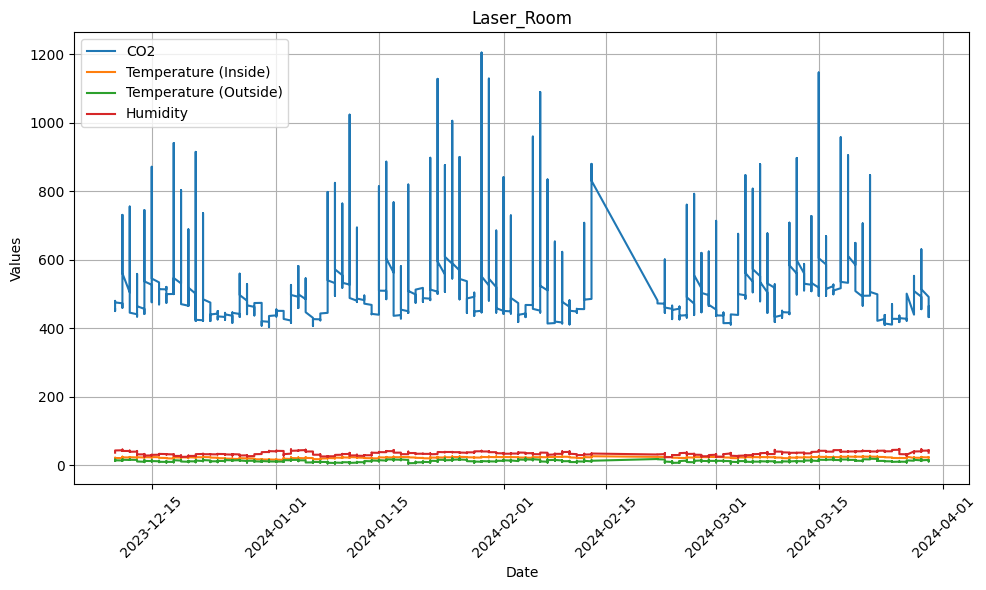

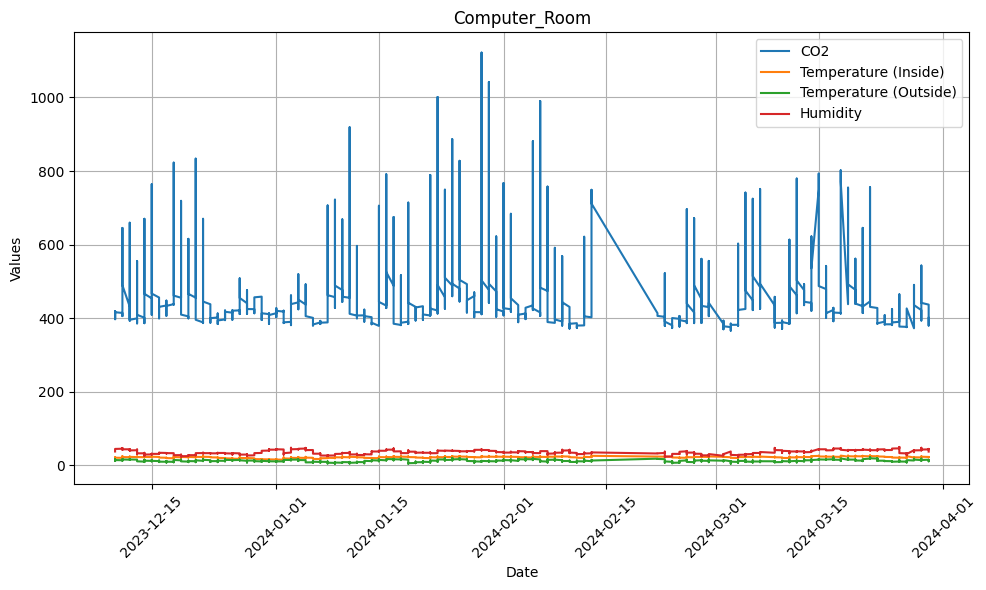

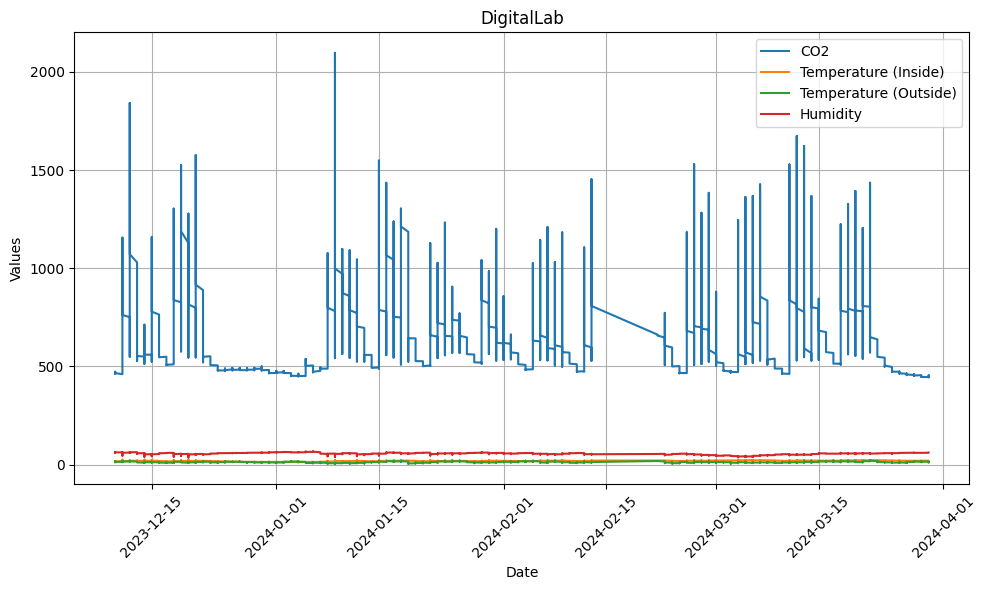

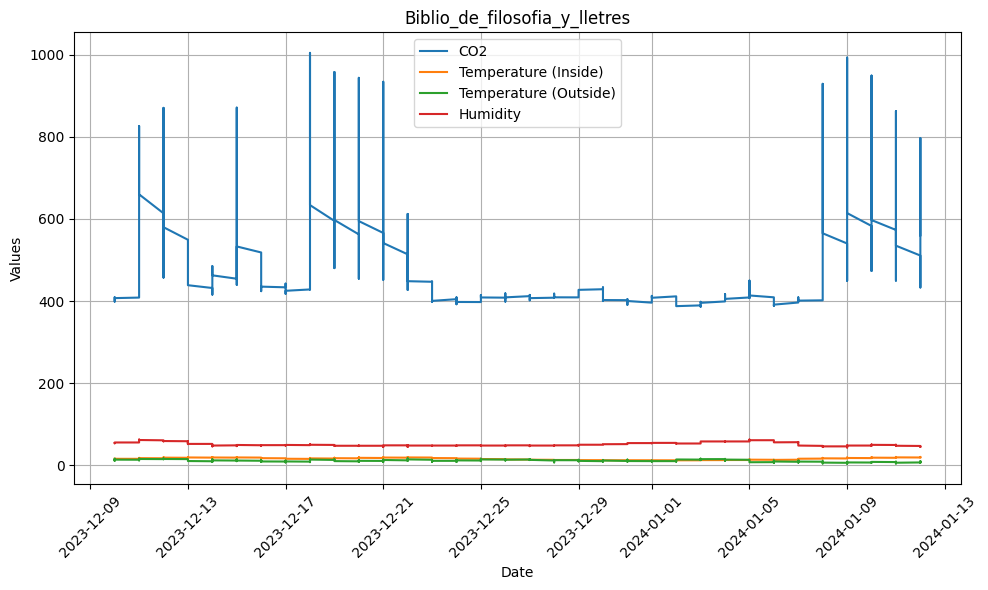

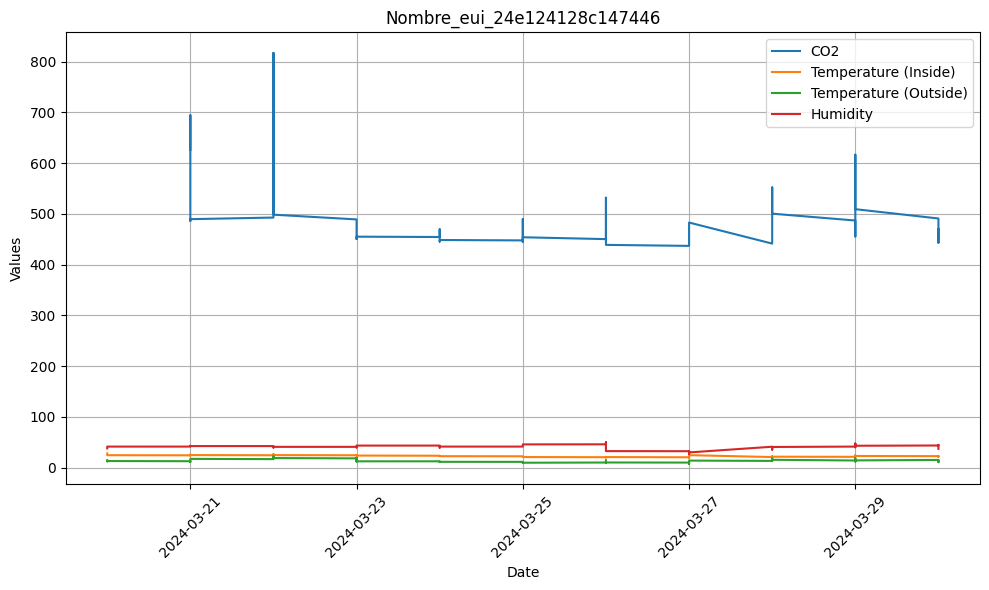

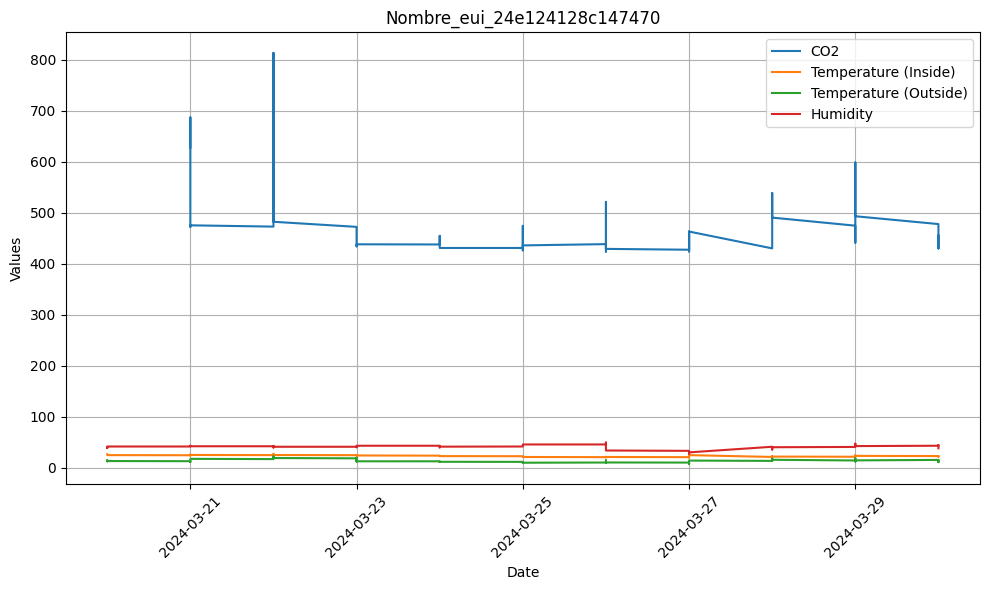

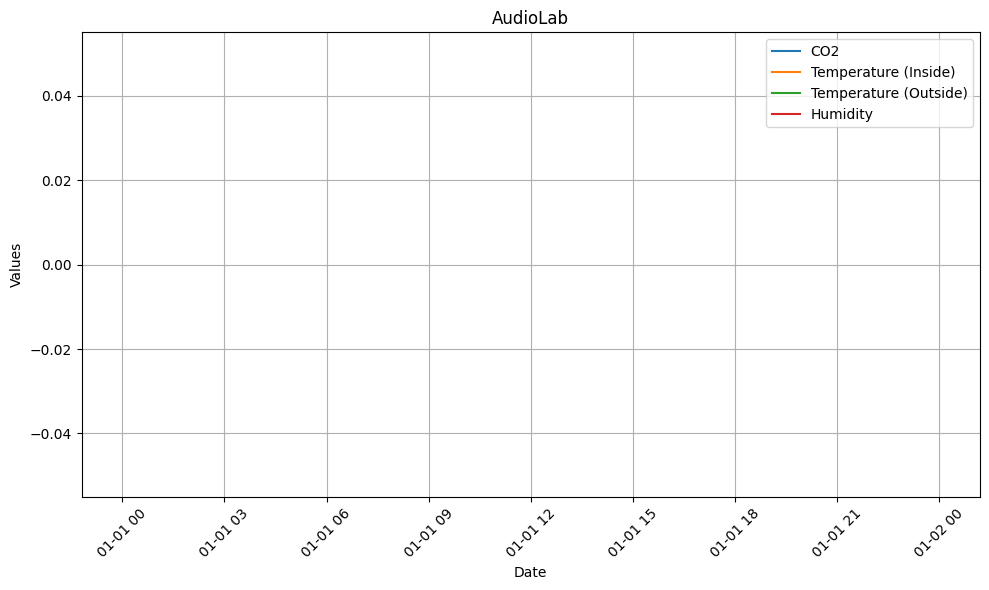

In [ ]:
import matplotlib.pyplot as plt

# Recorrer cada conjunto de datos fusionado en merged_datasets
for name, data in merged_datasets.items():
    # Crear una nueva figura
    plt.figure(figsize=(10, 6))

    # Graficar el CO2, la temperatura interior, la temperatura exterior y la humedad
    plt.plot(data['date'], data['co2'], label='CO2')
    plt.plot(data['date'], data['inside_temperature'], label='Temperature (Inside)')
    plt.plot(data['date'], data['outside_temperature'], label='Temperature (Outside)')
    plt.plot(data['date'], data['humidity'], label='Humidity')

    # Configurar etiquetas y título
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(name)

    # Rotar las etiquetas del eje x para que sean legibles
    plt.xticks(rotation=45)

    # Agregar leyenda
    plt.legend()

    # Mostrar la gráfica
    plt.grid(True)
    plt.tight_layout()
    plt.show()


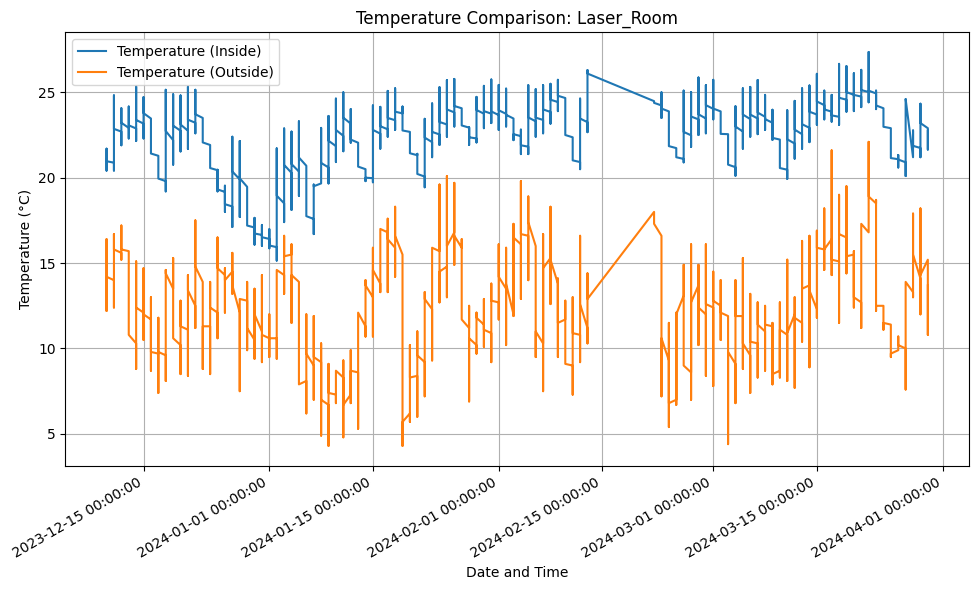

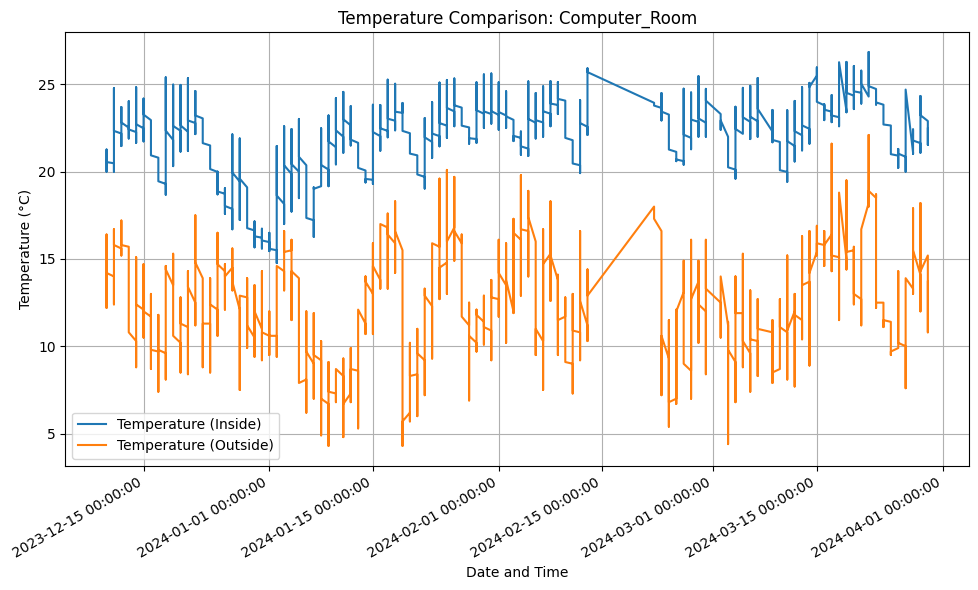

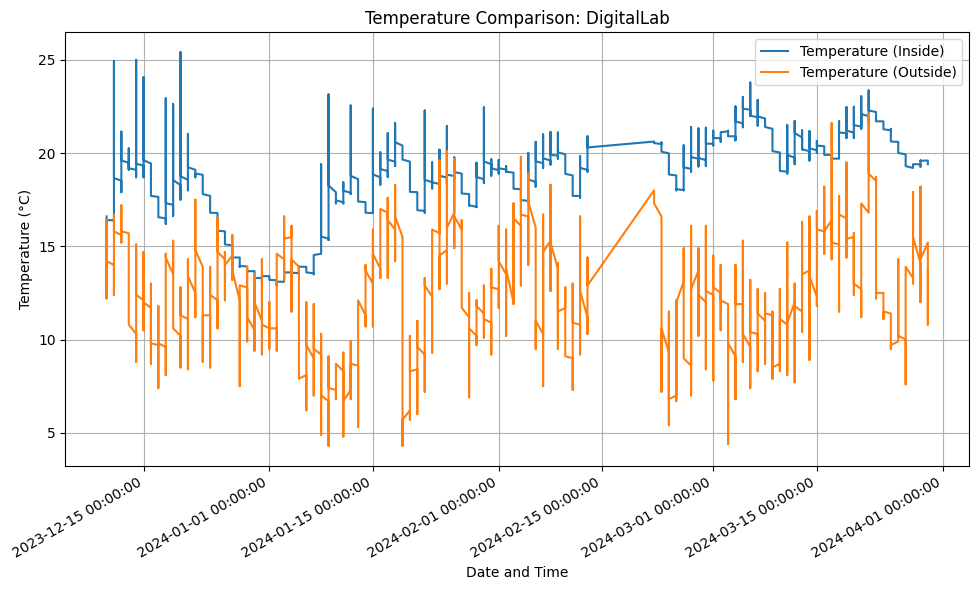

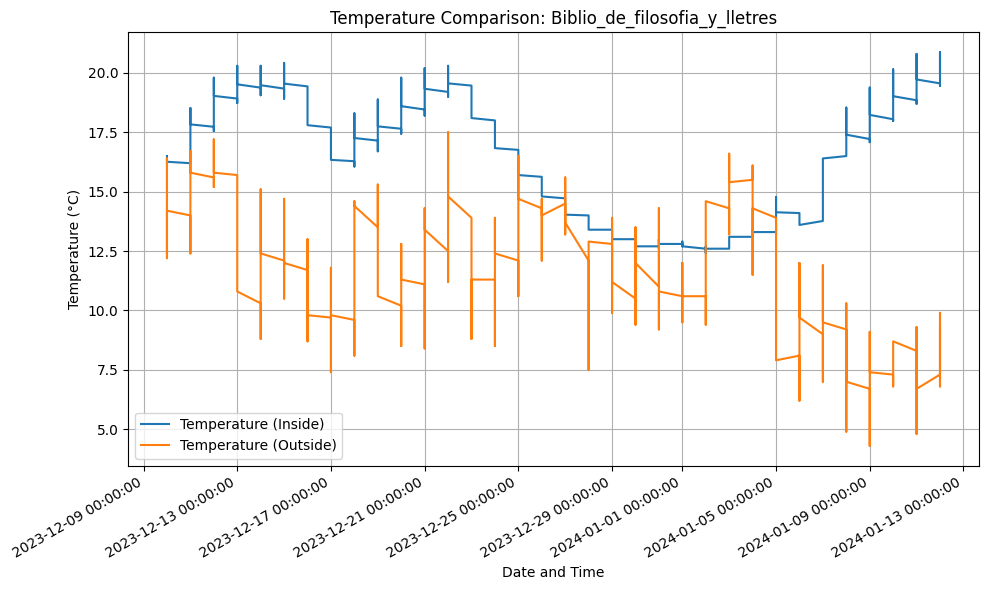

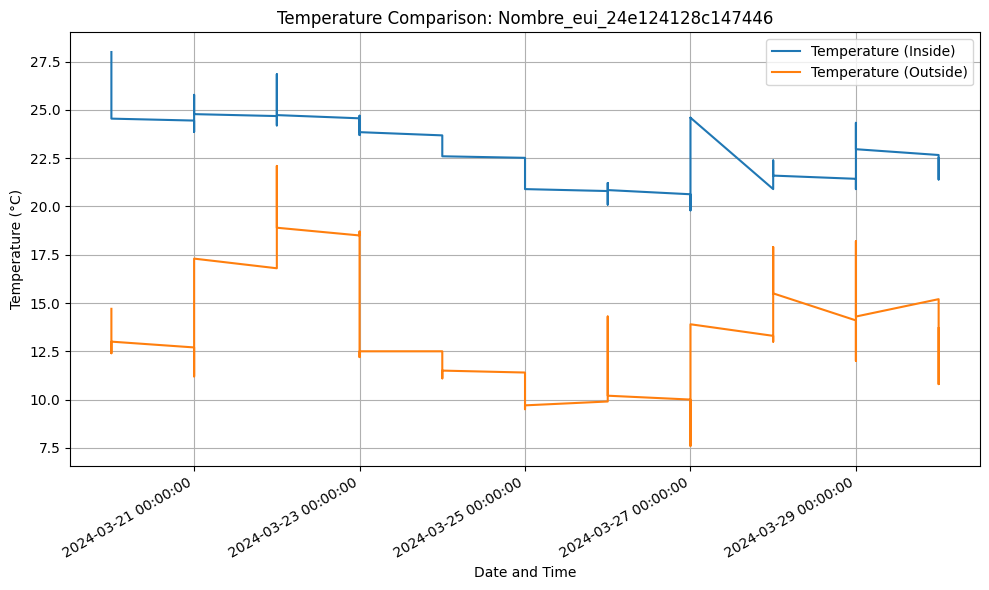

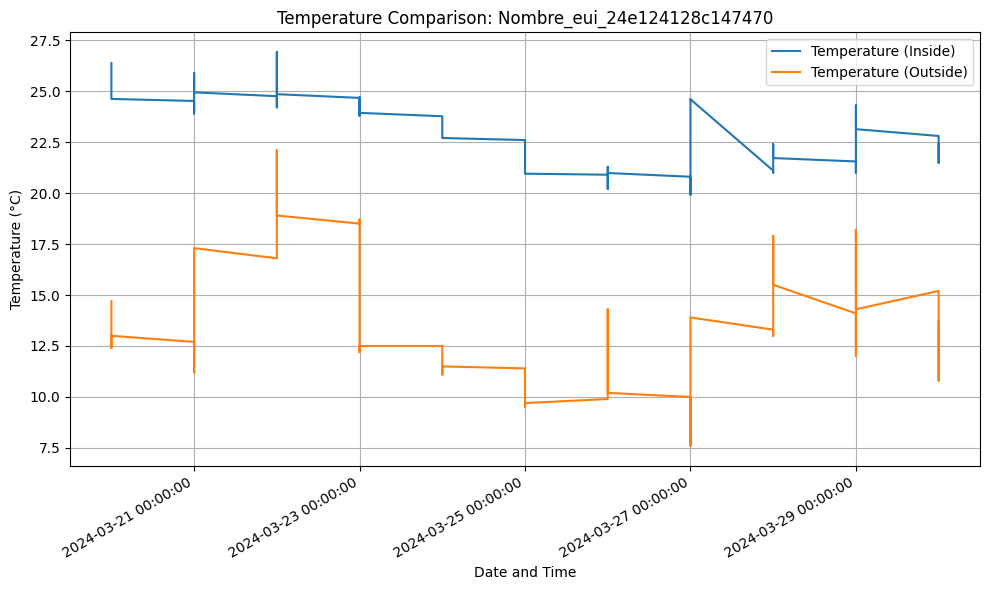

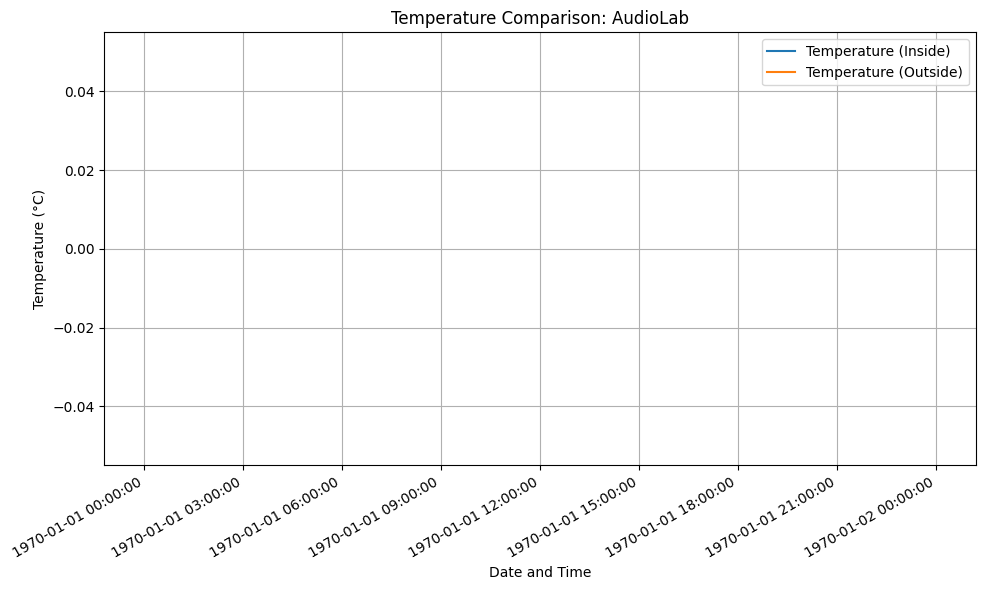

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Recorrer cada conjunto de datos fusionado en merged_datasets
for name, data in merged_datasets.items():
    # Crear una nueva figura
    plt.figure(figsize=(10, 6))

    # Graficar la temperatura interior y exterior
    plt.plot(data['date'], data['inside_temperature'], label='Temperature (Inside)')
    plt.plot(data['date'], data['outside_temperature'], label='Temperature (Outside)')

    # Configurar etiquetas y título
    plt.xlabel('Date and Time')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Temperature Comparison: {name}')

    # Rotar las etiquetas del eje x para que sean legibles
    plt.xticks(rotation=45)

    # Formatear las etiquetas del eje x para incluir fecha y hora
    date_format = DateFormatter("%Y-%m-%d %H:%M:%S")
    plt.gca().xaxis.set_major_formatter(date_format)

    # Ajustar el espaciado entre las etiquetas del eje x
    plt.gcf().autofmt_xdate()

    # Agregar leyenda
    plt.legend()

    # Mostrar la gráfica
    plt.grid(True)
    plt.tight_layout()
    plt.show()


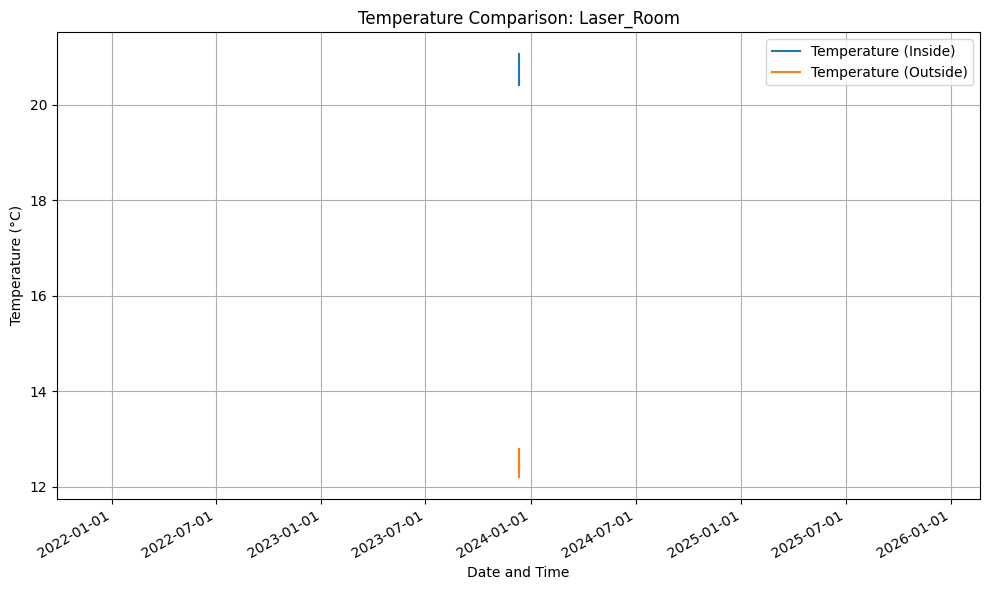

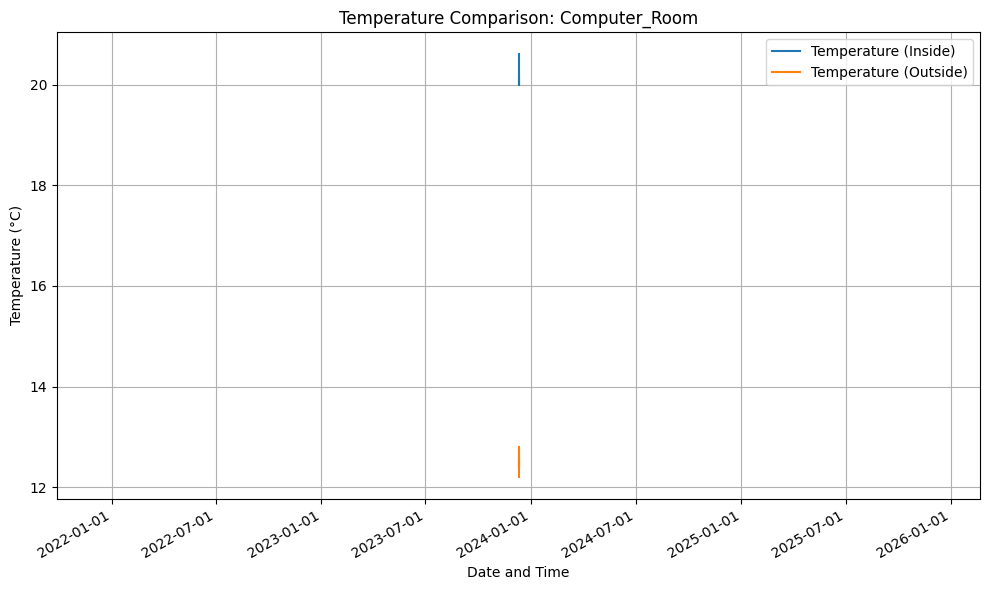

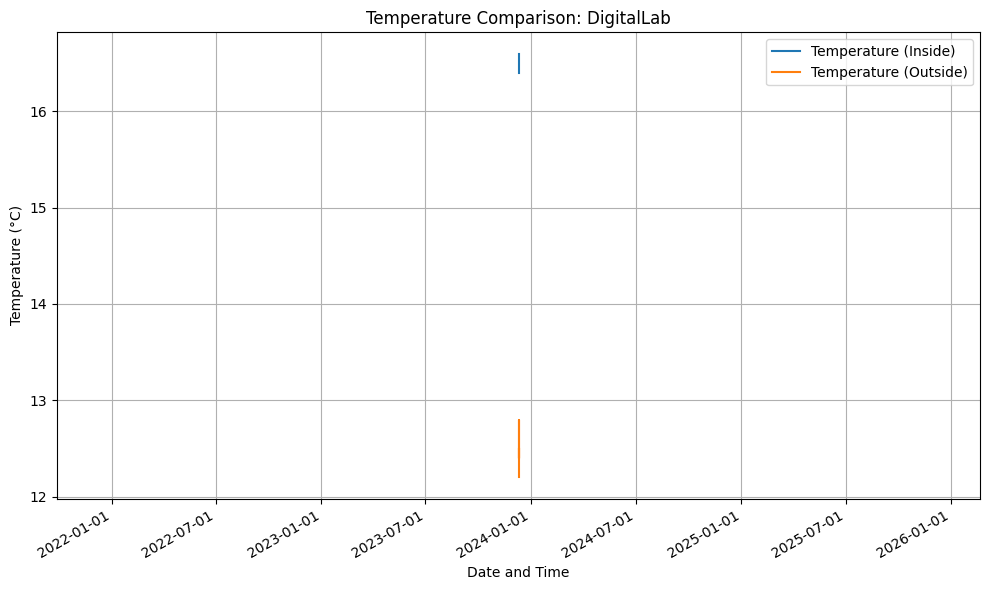

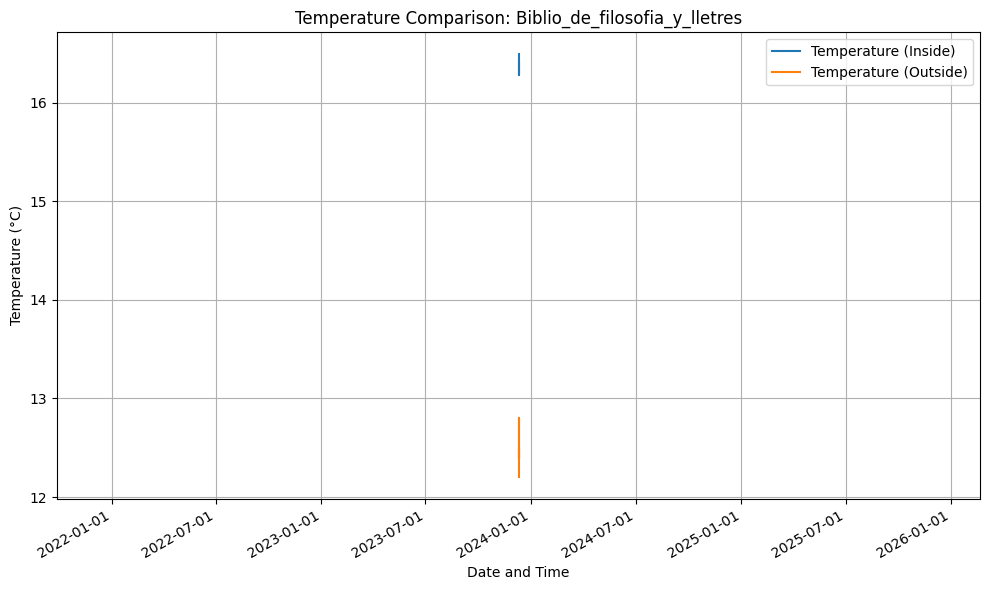

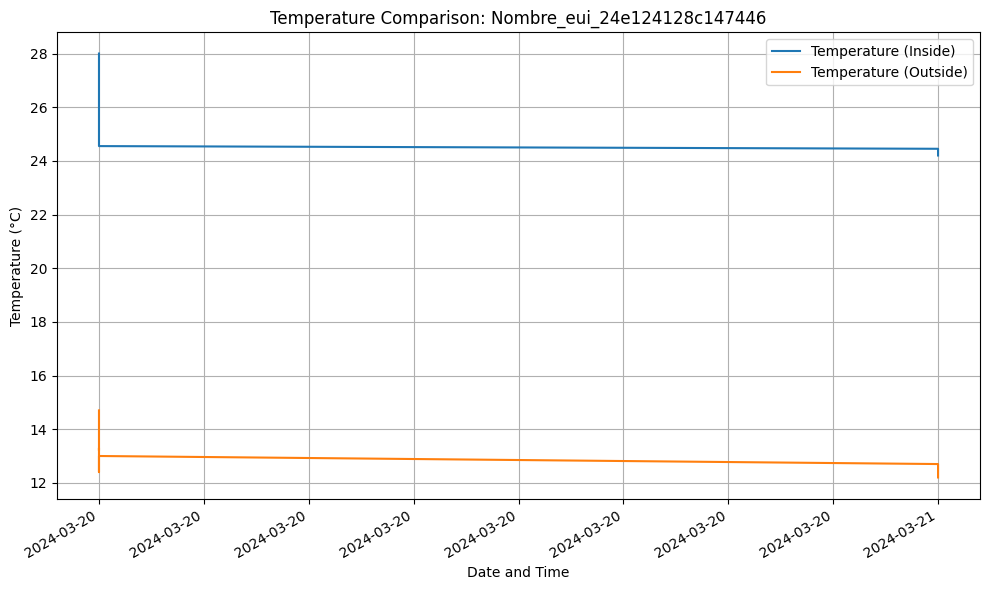

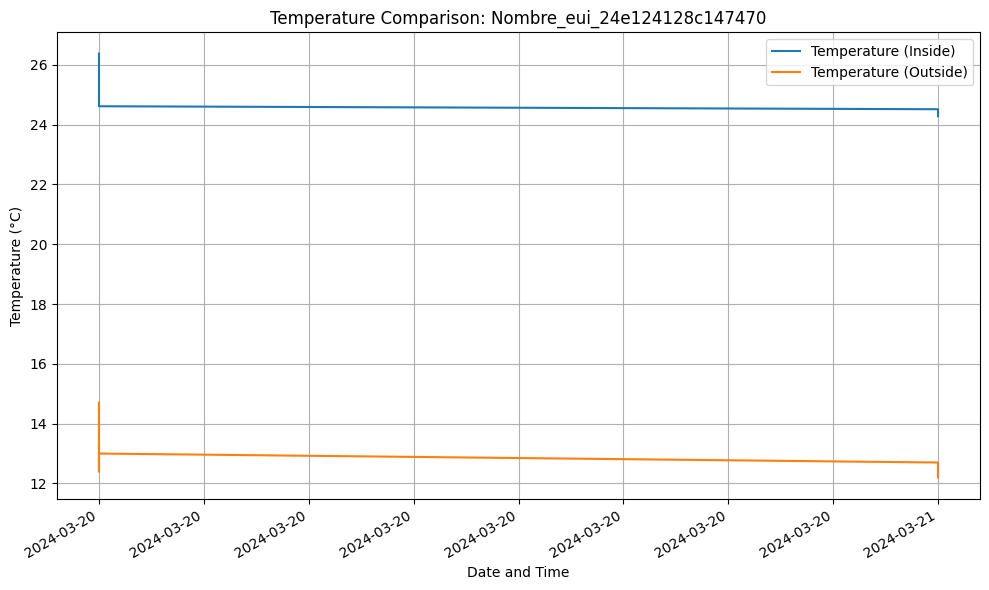

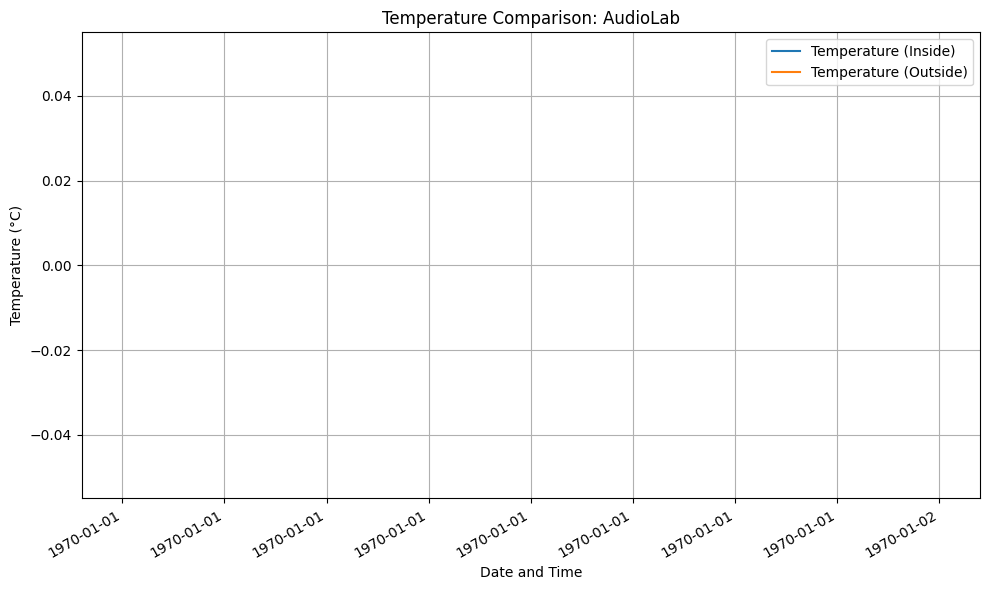

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Recorrer cada conjunto de datos fusionado en merged_datasets
for name, data in merged_datasets.items():
    # Crear una nueva figura
    plt.figure(figsize=(10, 6))

    # Seleccionar solo un subconjunto de fechas para mostrar (por ejemplo, las primeras 10 fechas)
    subset_data = data.iloc[:10]

    # Graficar la temperatura interior y exterior
    plt.plot(subset_data['date'], subset_data['inside_temperature'], label='Temperature (Inside)')
    plt.plot(subset_data['date'], subset_data['outside_temperature'], label='Temperature (Outside)')

    # Configurar etiquetas y título
    plt.xlabel('Date and Time')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Temperature Comparison: {name}')

    # Rotar las etiquetas del eje x para que sean legibles
    plt.xticks(rotation=45)

    # Formatear las etiquetas del eje x para incluir solo la fecha
    date_format = DateFormatter("%Y-%m-%d")
    plt.gca().xaxis.set_major_formatter(date_format)

    # Ajustar el espaciado entre las etiquetas del eje x
    plt.gcf().autofmt_xdate()

    # Agregar leyenda
    plt.legend()

    # Mostrar la gráfica
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Seleccionar solo las columnas necesarias para construir la tabla
data_to_pivot = merged_datasets['Laser_Room'][['date', 'hour', 'outside_temperature']]

# Pivotar los datos para tener las horas como columnas
pivot_table = data_to_pivot.pivot(index='date', columns='hour', values='outside_temperature')

# Imprimir la tabla
print(pivot_table)

# Buscar los valores NaN en la tabla pivotada
nan_locations = pivot_table.isna()

# Filtrar la tabla pivotada para mostrar solo los valores True (NaN)
nan_locations = pivot_table[pivot_table.isna()]

# Imprimir los NaN
print(nan_locations)



hour        00:00:00  01:00:00  02:00:00  03:00:00  04:00:00  05:00:00  \
date                                                                     
2023-12-10       NaN       NaN      12.4      12.5      12.4      12.4   
2023-12-11      14.0      13.7      13.4      13.1      12.8      12.5   
2023-12-12      15.6      15.5      15.3      15.3      15.2      15.3   
2023-12-13      15.7      15.5      15.4      15.0      15.1      15.3   
2023-12-14      10.3      10.0      10.2       9.7       9.7       9.4   
...              ...       ...       ...       ...       ...       ...   
2024-03-26       9.9       9.9      10.0      10.1      10.2      10.5   
2024-03-27      10.0       8.9       8.8       8.5       8.2       8.4   
2024-03-28       NaN       NaN       NaN       NaN       NaN       NaN   
2024-03-29      14.1      13.2      13.8      13.6      12.6      13.3   
2024-03-30      15.2      12.0      13.2      13.3      13.3      13.7   

hour        06:00:00  07:00:00  08:00

In [ ]:
# Suponiendo que "Laser_Room" es tu DataFrame de Pandas
laser_room_data = merged_datasets['Laser_Room']
laser_room_data.to_csv('Laser_Room_dataset.csv', index=False)


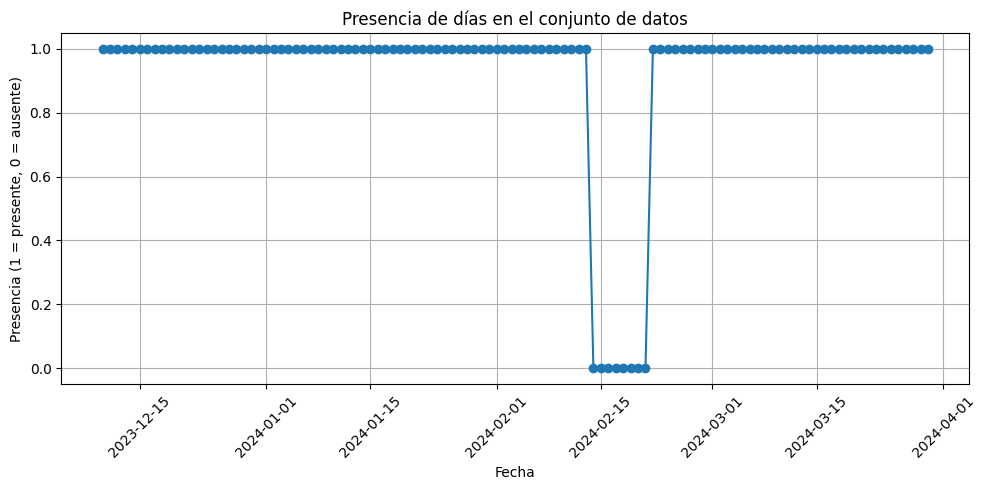

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Obtener el rango de fechas del conjunto de datos
start_date = merged_datasets['Laser_Room']['date'].min()
end_date = merged_datasets['Laser_Room']['date'].max()

# Crear una lista de días dentro de ese rango
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Verificar si cada día está presente en el conjunto de datos
presence = [1 if date in merged_datasets['Laser_Room']['date'].unique() else 0 for date in date_range]

# Crear el gráfico
plt.figure(figsize=(10, 5))
plt.plot(date_range, presence, marker='o', linestyle='-')
plt.title('Presencia de días en el conjunto de datos')
plt.xlabel('Fecha')
plt.ylabel('Presencia (1 = presente, 0 = ausente)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### Laser_Room

Real

In [ ]:
# Función para crear y guardar los gráficos
def save_plot(data, title, filename, comfort_range, x_format):
    if not data.empty:  # Verificar si hay datos
        plt.figure(figsize=(10, 6))
        plt.plot(data['datetime'], data['inside_temperature'], label='Inside Temperature')
        plt.plot(data['datetime'], data['outside_temperature'], label='Outside Temperature')
        plt.axhspan(*comfort_range, color='green', alpha=0.3, label=f'Comfort Zone ({comfort_range[0]}-{comfort_range[1]}°C)')
        plt.title(title)
        plt.xlabel('Date and Time')
        plt.ylabel('Temperature (°C)')
        plt.xticks(rotation=45)

        if x_format == 'day':
            plt.gca().xaxis.set_major_formatter(DateFormatter("%H"))
            plt.xticks(range(0, 24))  # Mostrar solo las horas del día
        elif x_format == 'week':
            plt.gca().xaxis.set_major_formatter(DateFormatter("%A"))
        elif x_format == 'month':
            plt.gca().xaxis.set_major_formatter(DateFormatter("Week %U"))

        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'tempimages/{filename}.png')  # Cambiado a 'tempimages'
        plt.close()
    else:
        print(f"No hay datos para graficar: {title}")

# Generar gráficos por mes, semana y día
months = Laser_Room_data['month'].unique()
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']  # Lista de días de la semana

for month in months:
    month_data = Laser_Room_data[Laser_Room_data['month'] == month].copy()
    comfort_range = comfort_zone(month)
    month_data['week'] = month_data['datetime'].dt.isocalendar().week - month_data['datetime'].dt.to_period('M').apply(lambda r: r.start_time.isocalendar()[1]) + 1

    # Gráfico mensual
    save_plot(month_data, f'Temperature in {month}', f'real-LaserRoom-{month}-None-None', comfort_range, 'month')

    weeks = month_data['week'].unique()
    for week in weeks:
        week_data = month_data[month_data['week'] == week].copy()

        # Gráfico semanal
        save_plot(week_data, f'Temperature in {month} - Week {week}', f'real-LaserRoom-{month}-Week{week}-None', comfort_range, 'week')

        for day in days_of_week:
            day_data = week_data[week_data['day_of_week'] == day].copy()
            print(day_data.head())

            # Gráfico diario
            save_plot(day_data, f'Temperature in {month} - Week {week} - {day}', f'real-LaserRoom-{month}-Week{week}-{day}', comfort_range, 'day')

print("Gráficos generados y guardados en la carpeta 'tempimages'.")


Empty DataFrame
Columns: [date, hour, co2, humidity, inside_temperature, outside_temperature, datetime, month, week, day_of_week, day_of_month]
Index: []
No hay datos para graficar: Temperature in December - Week 2 - Monday
Empty DataFrame
Columns: [date, hour, co2, humidity, inside_temperature, outside_temperature, datetime, month, week, day_of_week, day_of_month]
Index: []
No hay datos para graficar: Temperature in December - Week 2 - Tuesday
Empty DataFrame
Columns: [date, hour, co2, humidity, inside_temperature, outside_temperature, datetime, month, week, day_of_week, day_of_month]
Index: []
No hay datos para graficar: Temperature in December - Week 2 - Wednesday
Empty DataFrame
Columns: [date, hour, co2, humidity, inside_temperature, outside_temperature, datetime, month, week, day_of_week, day_of_month]
Index: []
No hay datos para graficar: Temperature in December - Week 2 - Thursday
Empty DataFrame
Columns: [date, hour, co2, humidity, inside_temperature, outside_temperature, date

In [ ]:
Laser_Room_data = merged_datasets['Laser_Room']
# print(Laser_Room_data.info())
print(Laser_Room_data)

# Paso 1: Obtener la fecha mínima y máxima
min_date = Laser_Room_data['datetime'].min().date()
max_date = Laser_Room_data['datetime'].max().date()

# Paso 2: Crear un rango de fechas completo
complete_date_range = pd.date_range(start=min_date, end=max_date)

# Paso 3: Encontrar las fechas faltantes
missing_dates = complete_date_range[~complete_date_range.isin(Laser_Room_data['datetime'].dt.date)]

# Imprimir resultados
print("Fecha mínima con datos:", min_date)
print("Fecha máxima con datos:", max_date)
if len(missing_dates) == 0:
    print("No hay ningún día faltante en el rango.")
else:
    print("Hay días faltantes en el rango:")
    print(missing_dates)


# Verificar si hay NaN en la temperatura interior
missing_temp = Laser_Room_data[Laser_Room_data['inside_temperature'].isna()]

if len(missing_temp) == 0:
    print("No hay valores NaN en la temperatura interior.")
else:
    print("Hay valores NaN en la temperatura interior en las siguientes filas:")
    print(missing_temp)




           date      hour         co2   humidity  inside_temperature  \
0    2023-12-10  02:00:00  455.833333  36.500000           21.066667   
1    2023-12-10  03:00:00  451.500000  36.500000           21.000000   
2    2023-12-10  04:00:00  450.166667  36.500000           20.916667   
3    2023-12-10  05:00:00  453.333333  36.500000           20.816667   
4    2023-12-10  06:00:00  452.333333  36.500000           20.766667   
...         ...       ...         ...        ...                 ...   
2426 2024-03-30  08:00:00  432.600000  39.000000           21.860000   
2427 2024-03-30  09:00:00  434.833333  38.916667           21.900000   
2428 2024-03-30  10:00:00  435.666667  38.500000           21.916667   
2429 2024-03-30  11:00:00  473.000000  38.166667           21.966667   
2430 2024-03-30  12:00:00  463.200000  36.500000           22.740000   

      outside_temperature            datetime     month  week day_of_week  \
0                    12.4 2023-12-10 02:00:00  December   

In [ ]:
from google.colab import files
for i in os.listdir('/content/tempimages') :
 #print(i)
 files.download('/content/tempimages/'+i)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import shutil

def clear_folder(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

# Ruta de la carpeta que quieres limpiar
folder_path = '/content/tempimages'

# Llama a la función para limpiar la carpeta
clear_folder(folder_path)


Averages

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2431 entries, 0 to 2430
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 2431 non-null   datetime64[ns]
 1   hour                 2431 non-null   object        
 2   co2                  2431 non-null   float64       
 3   humidity             2431 non-null   float64       
 4   inside_temperature   2431 non-null   float64       
 5   outside_temperature  2431 non-null   float64       
 6   datetime             2431 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(4), object(1)
memory usage: 133.1+ KB
None


<ipython-input-50-a1a99fa1795b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_data['day_of_week'] = month_data['datetime'].dt.day_name()
<ipython-input-50-a1a99fa1795b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_data['hour'] = pd.to_datetime(month_data['hour'], format='%H:%M:%S').dt.hour


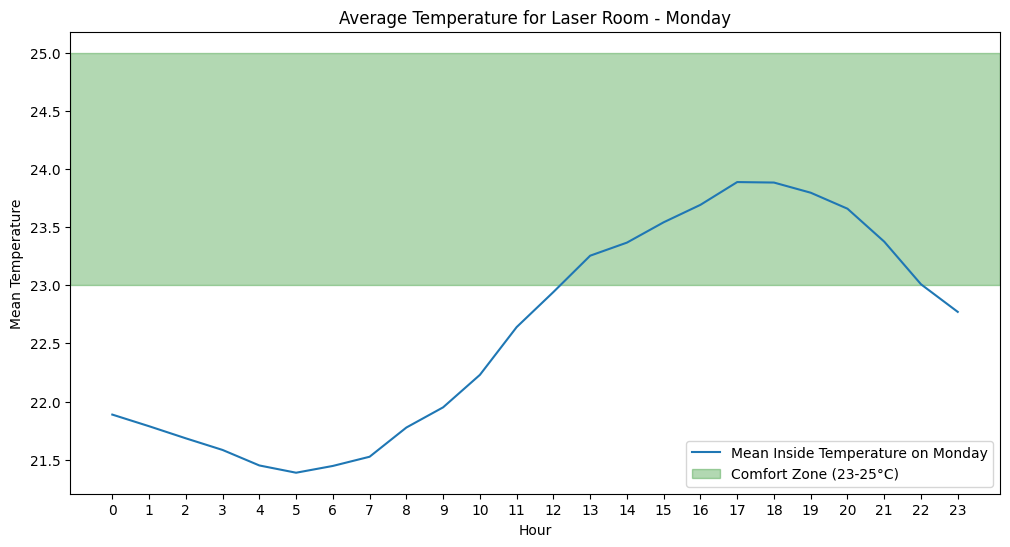

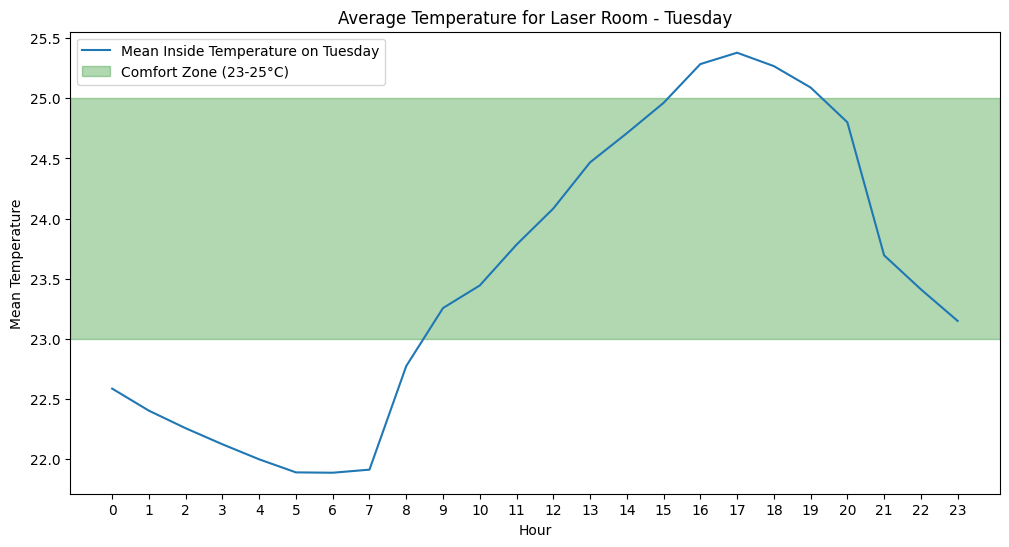

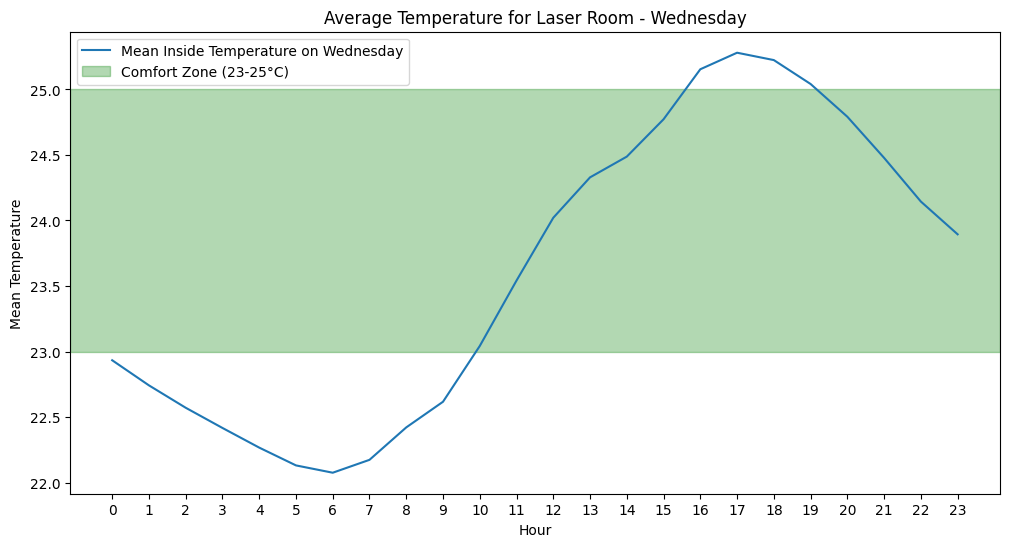

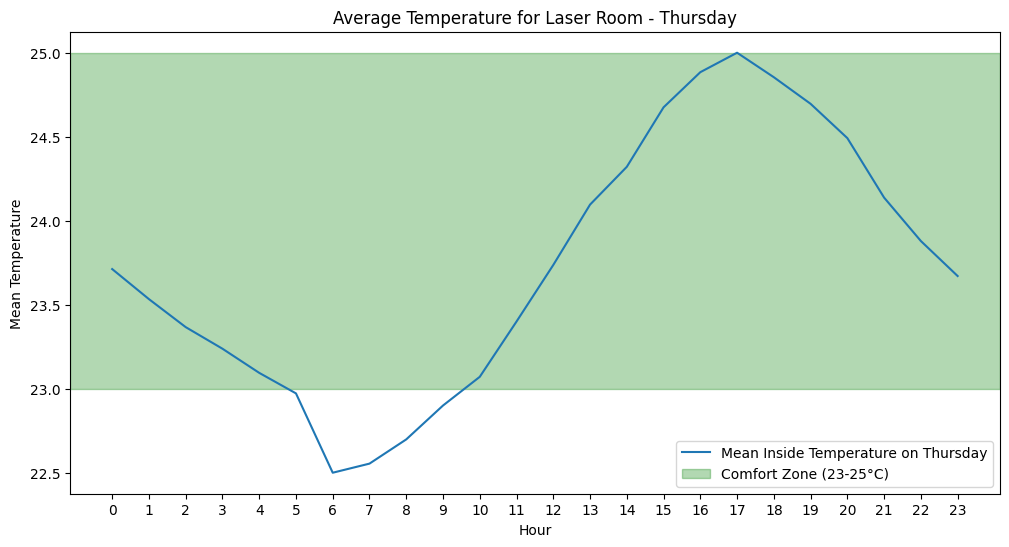

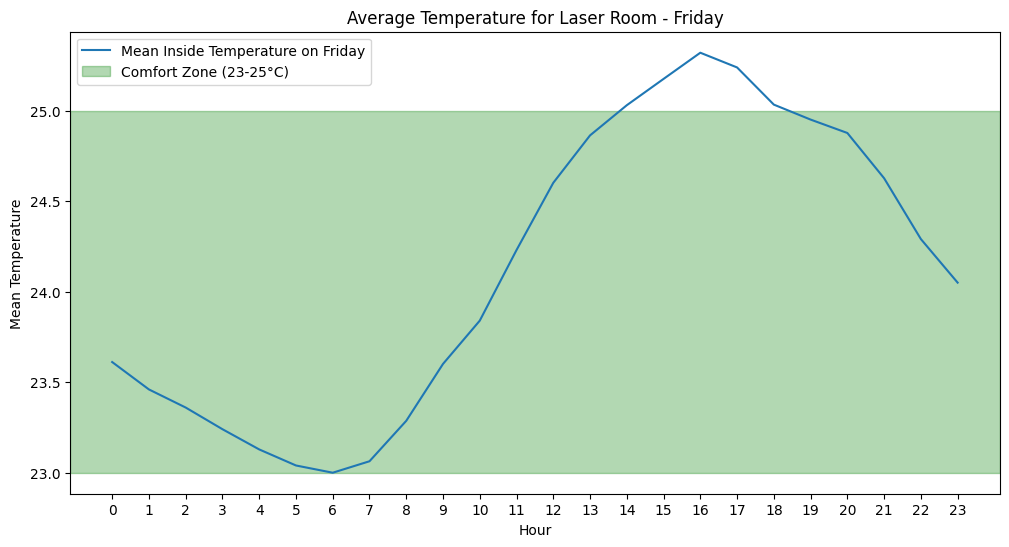

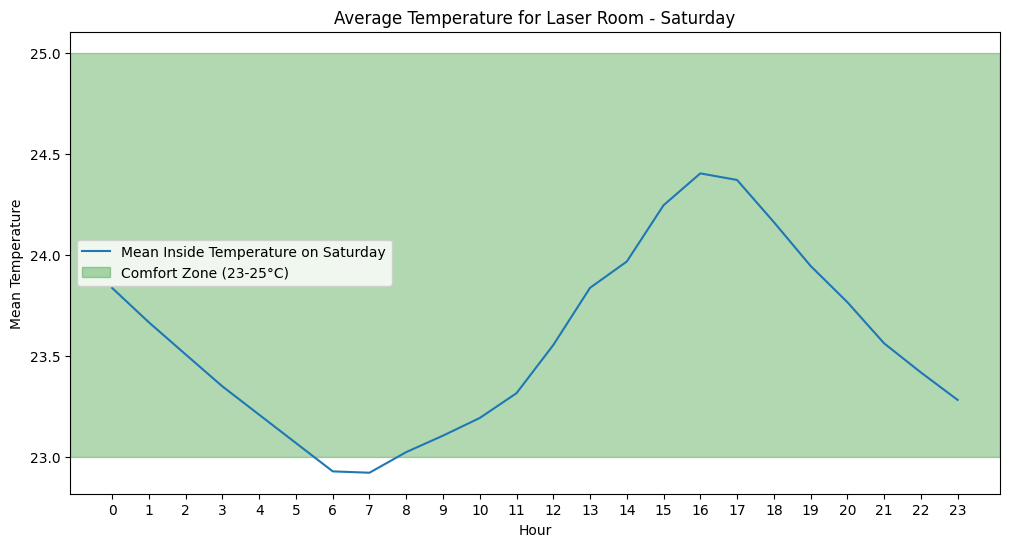

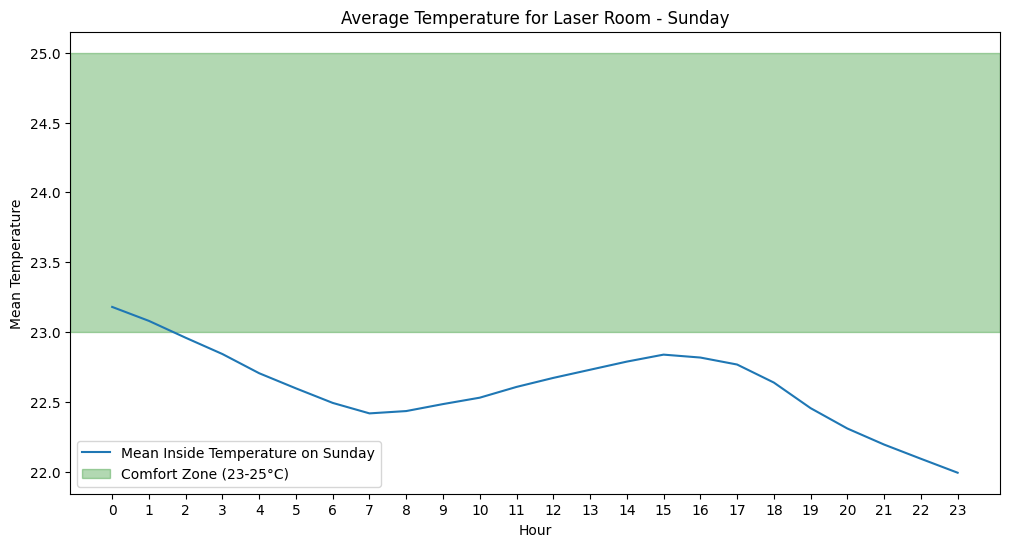

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

Laser_Room_data = merged_datasets['Laser_Room']

print(Laser_Room_data.info())

# Crear una columna datetime combinando 'date' y 'hour'
Laser_Room_data['datetime'] = pd.to_datetime(Laser_Room_data['date'].astype(str) + ' ' + Laser_Room_data['hour'].astype(str))

# Seleccionar un mes específico
start_date = '2024-03-01'  # Ajusta esta fecha según tus datos
end_date = '2024-03-31'    # Ajusta esta fecha según tus datos
month_data = Laser_Room_data[(Laser_Room_data['datetime'] >= start_date) & (Laser_Room_data['datetime'] <= end_date)]

# Agregar columna con el día de la semana
month_data['day_of_week'] = month_data['datetime'].dt.day_name()

# Convertir 'hour' a una hora numérica para facilitar la visualización
month_data['hour'] = pd.to_datetime(month_data['hour'], format='%H:%M:%S').dt.hour

# Agrupar por día de la semana y hora, y calcular la temperatura media
grouped = month_data.groupby(['day_of_week', 'hour']).agg({'inside_temperature': 'mean'}).reset_index()

# Crear un gráfico para cada día de la semana
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def plot_avg_temp_hour(data, day, title):
    plt.figure(figsize=(12, 6))
    day_data = data[data['day_of_week'] == day]
    plt.plot(day_data['hour'], day_data['inside_temperature'], label=f'Mean Inside Temperature on {day}')
    plt.axhspan(23, 25, color='green', alpha=0.3, label='Comfort Zone (23-25°C)')
    plt.title(f"{title} - {day}")
    plt.xlabel('Hour')
    plt.xticks(range(0, 24))  # Mostrar solo las horas
    plt.ylabel('Mean Temperature')
    plt.legend()
    plt.show()

# Plotting for each day of the week
for day in days_of_week:
    plot_avg_temp_hour(grouped, day, 'Average Temperature for Laser Room')


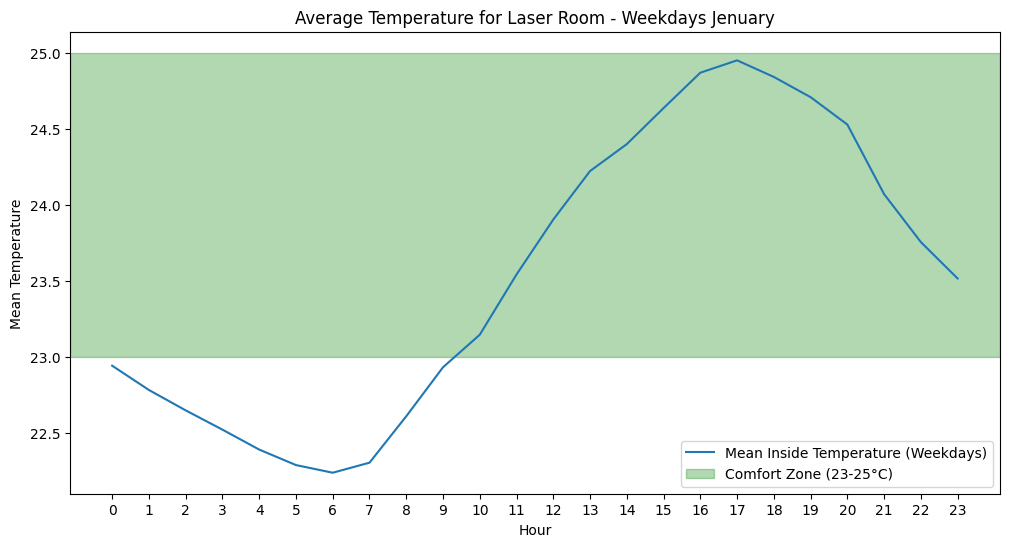

In [ ]:

# Filtrar los datos para excluir fines de semana
weekdays_data = month_data[~month_data['day_of_week'].isin(['Saturday', 'Sunday'])]

# Agrupar por hora y calcular la temperatura media para los días laborables
weekdays_grouped = weekdays_data.groupby('hour').agg({'inside_temperature': 'mean'}).reset_index()

# Crear un gráfico para los días laborables
def plot_avg_temp_weekdays(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['hour'], data['inside_temperature'], label='Mean Inside Temperature (Weekdays)')
    plt.axhspan(23, 25, color='green', alpha=0.3, label='Comfort Zone (23-25°C)')
    plt.title(title)
    plt.xlabel('Hour')
    plt.xticks(range(0, 24))  # Mostrar solo las horas
    plt.ylabel('Mean Temperature')
    plt.legend()
    plt.show()

# Plotting for weekdays
plot_avg_temp_weekdays(weekdays_grouped, 'Average Temperature for Laser Room - Weekdays Jenuary')

## Forecasting

Now we have a dictionary called **merged_datasets** with the datasets of the different locations, to acces them we have to use their name:
- Laser_Room *(2431 rows)*
- Computer_Room *(2312 rows)*
- DigitalLab (2441 rows)
- Biblio_de_filosofia_y_lletres *(812 rows)*
- Nombre_eui_24e124128c147446 *(227 rows)*
- Nombre_eui_24e124128c147470 *(227 rows)*
- AudioLab *(0 rows)*


In [ ]:
print(merged_datasets['Laser_Room'].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2431 entries, 0 to 2430
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 2431 non-null   datetime64[ns]
 1   hour                 2431 non-null   object        
 2   co2                  2431 non-null   float64       
 3   humidity             2431 non-null   float64       
 4   inside_temperature   2431 non-null   float64       
 5   outside_temperature  2431 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 114.1+ KB
None


In [ ]:
Laser_Room_data = merged_datasets['Laser_Room']

# Feature scaling
scaler = MinMaxScaler()
Laser_Room_data_scaled = scaler.fit_transform(Laser_Room_data[['co2', 'humidity', 'inside_temperature', 'outside_temperature']])

# Create training data
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, :])
    return np.array(X), np.array(Y)

look_back = 10
X, Y = create_dataset(Laser_Room_data_scaled, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], look_back, X.shape[2]))

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [ ]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 4)))
model.add(LSTM(50))
model.add(Dense(4))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), verbose=2)


Epoch 1/100
61/61 - 6s - loss: 0.0266 - val_loss: 0.0132 - 6s/epoch - 102ms/step
Epoch 2/100
61/61 - 1s - loss: 0.0099 - val_loss: 0.0102 - 571ms/epoch - 9ms/step
Epoch 3/100
61/61 - 1s - loss: 0.0084 - val_loss: 0.0086 - 680ms/epoch - 11ms/step
Epoch 4/100
61/61 - 1s - loss: 0.0068 - val_loss: 0.0073 - 558ms/epoch - 9ms/step
Epoch 5/100
61/61 - 0s - loss: 0.0055 - val_loss: 0.0059 - 404ms/epoch - 7ms/step
Epoch 6/100
61/61 - 0s - loss: 0.0049 - val_loss: 0.0064 - 360ms/epoch - 6ms/step
Epoch 7/100
61/61 - 0s - loss: 0.0044 - val_loss: 0.0067 - 390ms/epoch - 6ms/step
Epoch 8/100
61/61 - 0s - loss: 0.0039 - val_loss: 0.0047 - 401ms/epoch - 7ms/step
Epoch 9/100
61/61 - 0s - loss: 0.0034 - val_loss: 0.0044 - 393ms/epoch - 6ms/step
Epoch 10/100
61/61 - 0s - loss: 0.0030 - val_loss: 0.0035 - 381ms/epoch - 6ms/step
Epoch 11/100
61/61 - 0s - loss: 0.0027 - val_loss: 0.0054 - 384ms/epoch - 6ms/step
Epoch 12/100
61/61 - 0s - loss: 0.0026 - val_loss: 0.0030 - 367ms/epoch - 6ms/step
Epoch 13/100


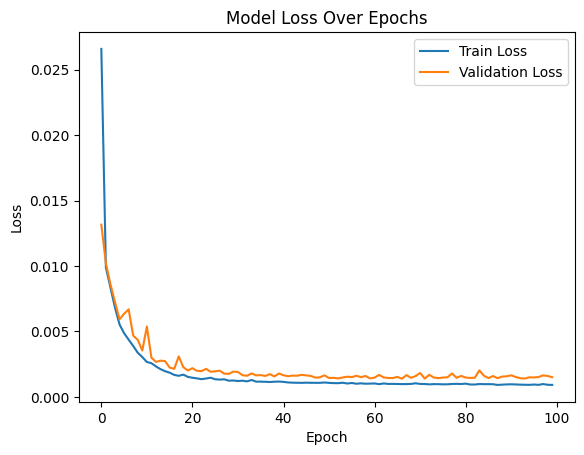

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train_inv = scaler.inverse_transform(Y_train)
test_predict = scaler.inverse_transform(test_predict)
Y_test_inv = scaler.inverse_transform(Y_test)

# Calculate mean values for next year in February for the given location
future_steps = 60  # Example: Predict next 30 days
last_values = Laser_Room_data_scaled[-look_back:]
input_data = np.reshape(last_values, (1, look_back, 4))

predictions = []
for _ in range(future_steps):
    next_pred = model.predict(input_data)
    predictions.append(next_pred[0])
    input_data = np.append(input_data[:, 1:, :], [next_pred], axis=1)

# Inverse transform predictions
predictions = scaler.inverse_transform(predictions)
pred_mean = np.mean(predictions, axis=0)

print(f"Predicted mean values for February next year in room Laser_Room:")
print(f"CO2: {pred_mean[0]:.2f}, Humidity: {pred_mean[1]:.2f}, Indoor Temperature: {pred_mean[2]:.2f}, Outdoor Temperature: {pred_mean[3]:.2f}")


1/1 [==============================] - 0s 19ms/step
Predicted mean values for February next year in room Laser_Room:
CO2: 777.49, Humidity: 38.86, Indoor Temperature: 22.48, Outdoor Temperature: 12.75


In [ ]:
print(pred_mean[0], pred_mean[1], pred_mean[2], pred_mean[3])

777.493349170105 38.863146218160786 22.48233618330955 12.747347842057545


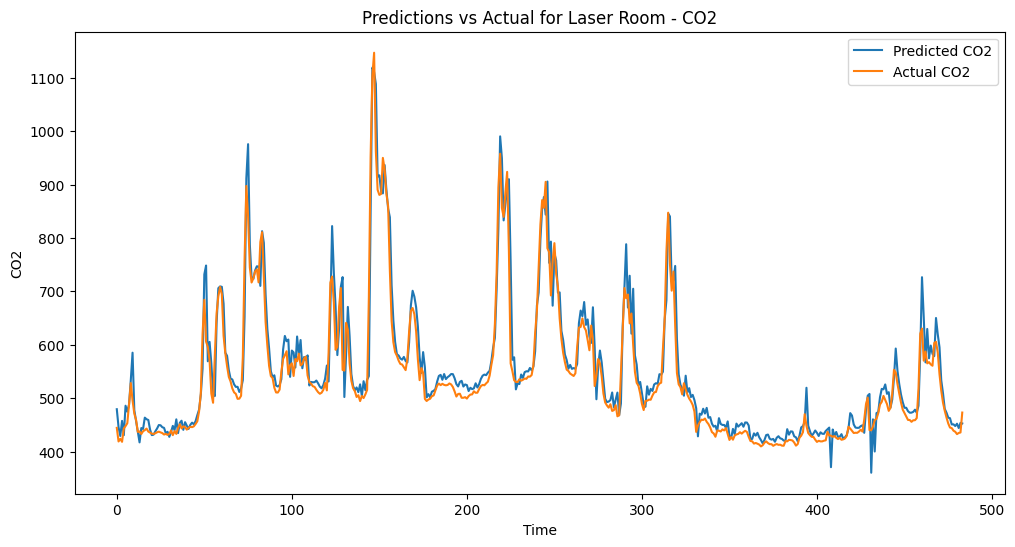

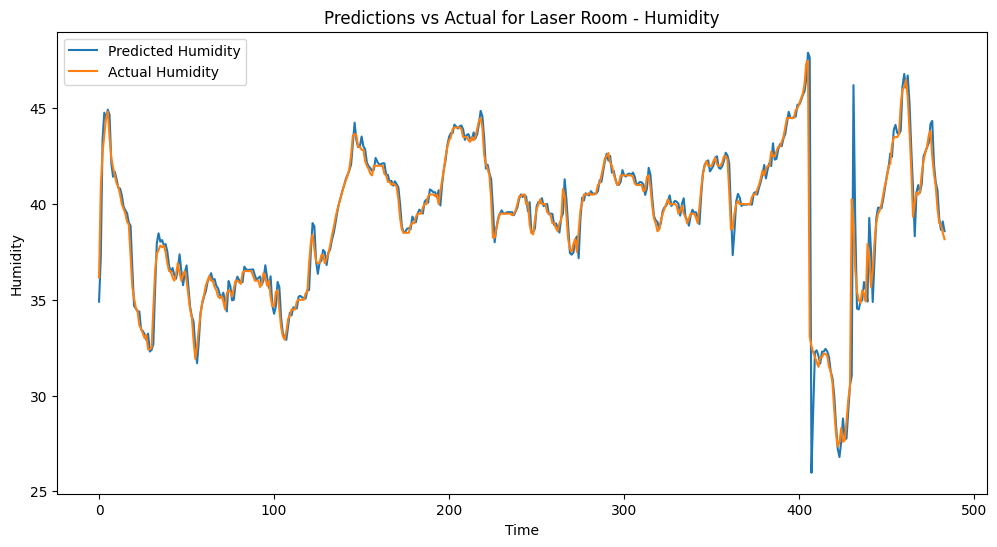

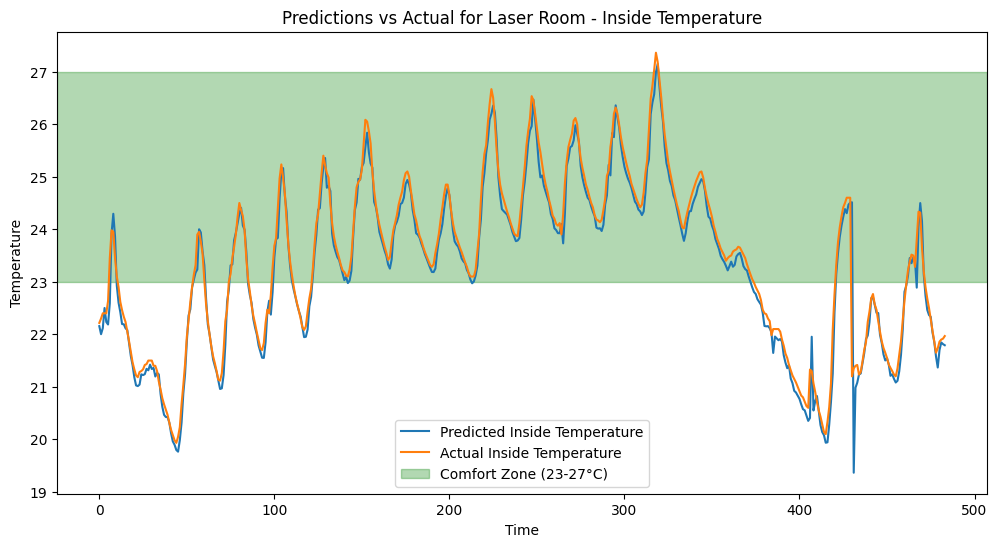

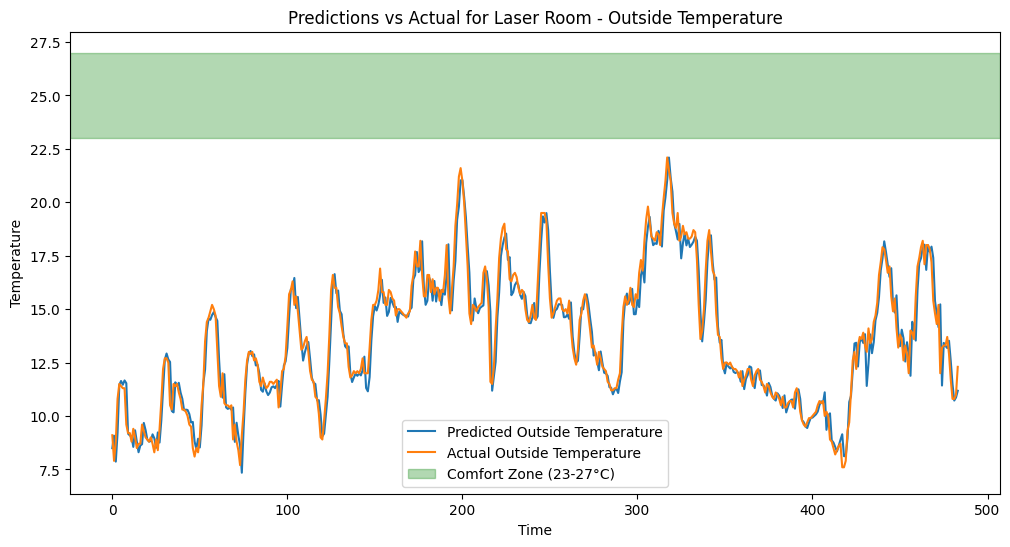

In [ ]:
from matplotlib import pyplot as plt

# Plot predictions vs actual values for CO2
def plot_predictions_co2(predictions, actual, title):
    plt.figure(figsize=(12, 6))
    plt.plot(predictions[:, 0], label='Predicted CO2')
    plt.plot(actual[:, 0], label='Actual CO2')
    plt.title(title + ' - CO2')
    plt.xlabel('Time')
    plt.ylabel('CO2')
    plt.legend()
    plt.show()

# Plot predictions vs actual values for humidity
def plot_predictions_hum(predictions, actual, title):
    plt.figure(figsize=(12, 6))
    plt.plot(predictions[:, 1], label='Predicted Humidity')
    plt.plot(actual[:, 1], label='Actual Humidity')
    plt.title(title + ' - Humidity')
    plt.xlabel('Time')
    plt.ylabel('Humidity')
    plt.legend()
    plt.show()

# Plot predictions vs actual values for inside temperature
def plot_predictions_temp(predictions, actual, title):
    plt.figure(figsize=(12, 6))
    plt.plot(predictions[:, 2], label='Predicted Inside Temperature')
    plt.plot(actual[:, 2], label='Actual Inside Temperature')
    plt.axhspan(23, 27, color='green', alpha=0.3, label='Comfort Zone (23-27°C)')
    plt.title(title + ' - Inside Temperature')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

# Plot predictions vs actual values for outside temperature
def plot_predictions_outside_temp(predictions, actual, title):
    plt.figure(figsize=(12, 6))
    plt.plot(predictions[:, 3], label='Predicted Outside Temperature')
    plt.plot(actual[:, 3], label='Actual Outside Temperature')
    plt.axhspan(23, 27, color='green', alpha=0.3, label='Comfort Zone (23-27°C)')
    plt.title(title + ' - Outside Temperature')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

# Assuming Y_train_inv and Y_test_inv are your predictions and actual values respectively
plot_predictions_co2(test_predict, Y_test_inv, 'Predictions vs Actual for Laser Room')
plot_predictions_hum(test_predict, Y_test_inv, 'Predictions vs Actual for Laser Room')
plot_predictions_temp(test_predict, Y_test_inv, 'Predictions vs Actual for Laser Room')
plot_predictions_outside_temp(test_predict, Y_test_inv, 'Predictions vs Actual for Laser Room')


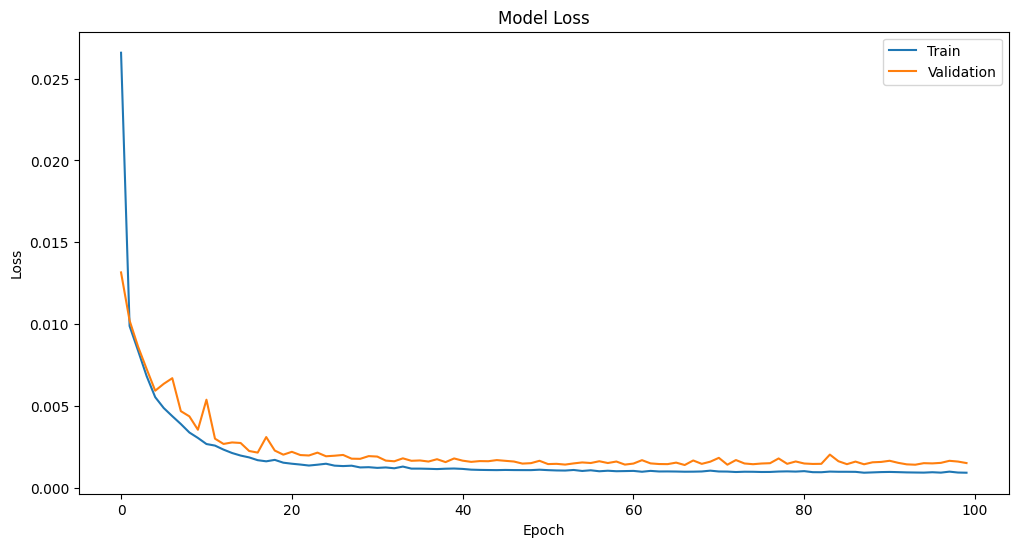

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()